# Principal Component Analysis of Raman Spectra

## Setup

Import required packages

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import style
from itertools import cycle
from sklearn.decomposition import PCA

from sklearn.preprocessing import Normalizer

from raman_lib.preprocessing import (BaselineCorrector,
                                     RangeLimiter,
                                     SavGolFilter)

from raman_lib.misc import load_data

style.use("default")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

Settings

In [14]:
# Path where the data is stored
data_path = "./results_qc/biofilme.csv"

# Spectral range to analyze
# Use 'None' to use the whole range'
wn_min = None
wn_max = None

# Window size for smoothing the spectra
# Higher means stronger smoothing
sg_window = 25

In [54]:
data = load_data(data_path)

if "file" in data.columns:
    X = data.drop(columns=["label", "file"])
else:
    X = data.drop(columns=["label"])
wns = np.asarray(X.columns.astype(float))
X = np.asarray(X)

y = np.asarray(data.label)
y, y_key = pd.factorize(y)

for i, label in enumerate(y_key):
    print(f"{label}: {i}")

1B: 0
2B: 1
PW: 2
W: 3
W+1B: 4
W+2B: 5


Text(0, 0.5, 'Intensity (-)')

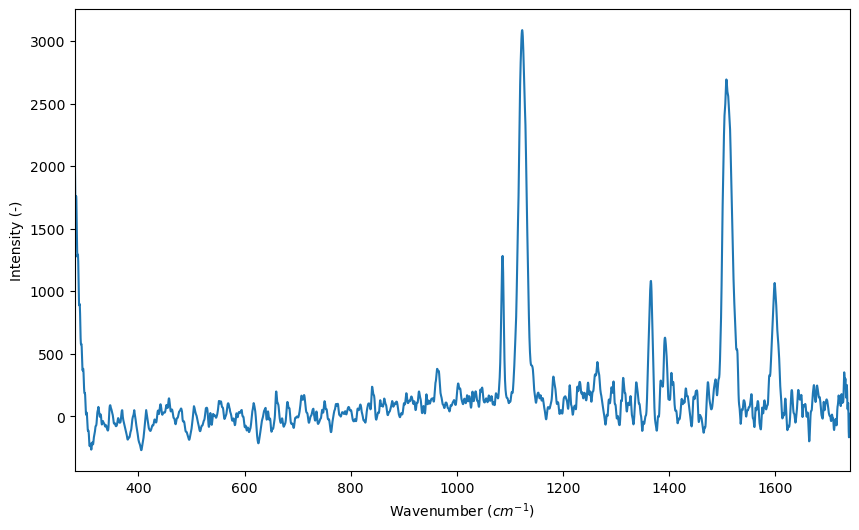

In [55]:
plt.plot(wns, X.mean(axis=0))
plt.margins(x=0)

plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

Text(0, 0.5, 'Intensity (-)')

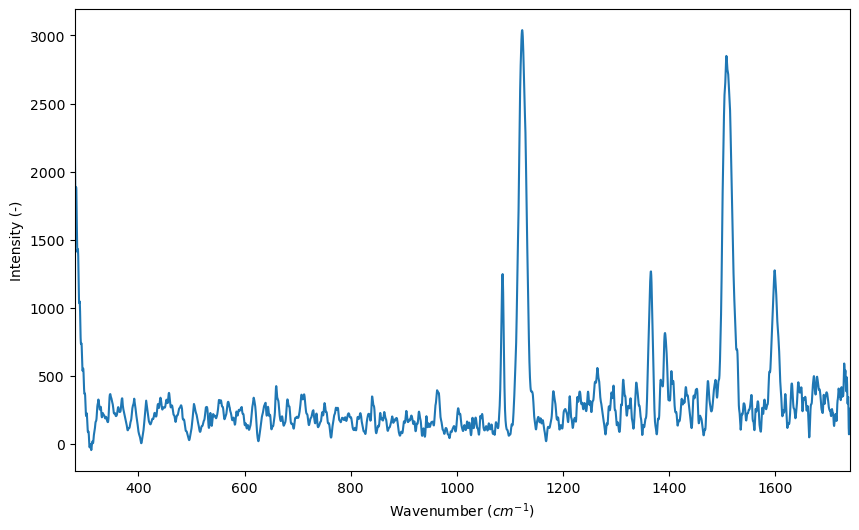

In [56]:
X_bl = BaselineCorrector().fit_transform(X)

plt.plot(wns, X_bl.mean(axis=0))
plt.margins(x=0)

plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

Text(0, 0.5, 'Intensity (-)')

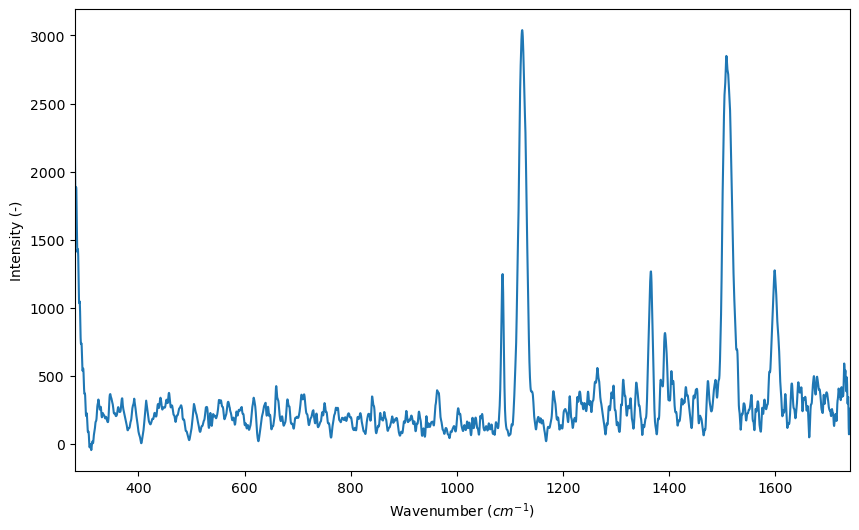

In [57]:
rl = RangeLimiter(lim=(wn_min, wn_max), reference=wns)
X_rl = rl.fit_transform(X_bl)
wns_reduced = wns[rl.lim_[0]:rl.lim_[1]]

plt.plot(wns_reduced, X_rl.mean(axis=0))
plt.margins(x=0)

plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

Text(0, 0.5, 'Intensity (-)')

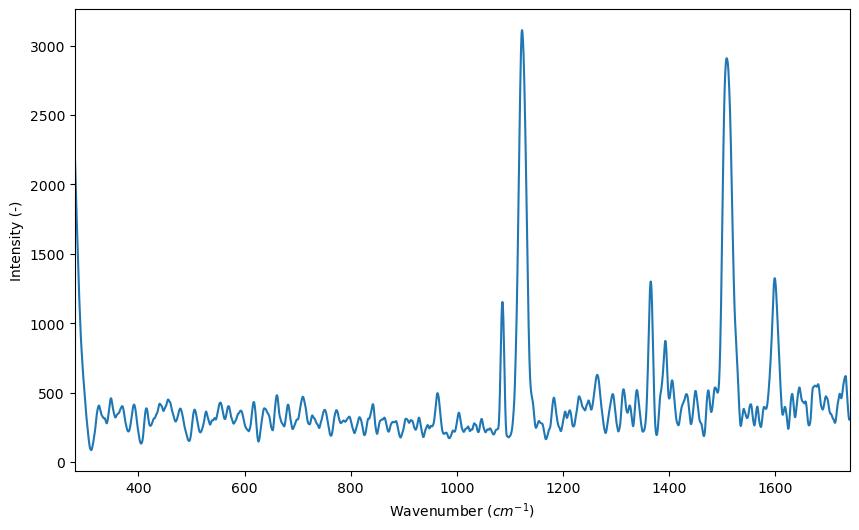

In [58]:
X_smooth = SavGolFilter(window=sg_window).fit_transform(X_rl)

plt.plot(wns_reduced, X_smooth.mean(axis=0))
plt.margins(x=0)

plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

Text(0, 0.5, 'Intensity (-)')

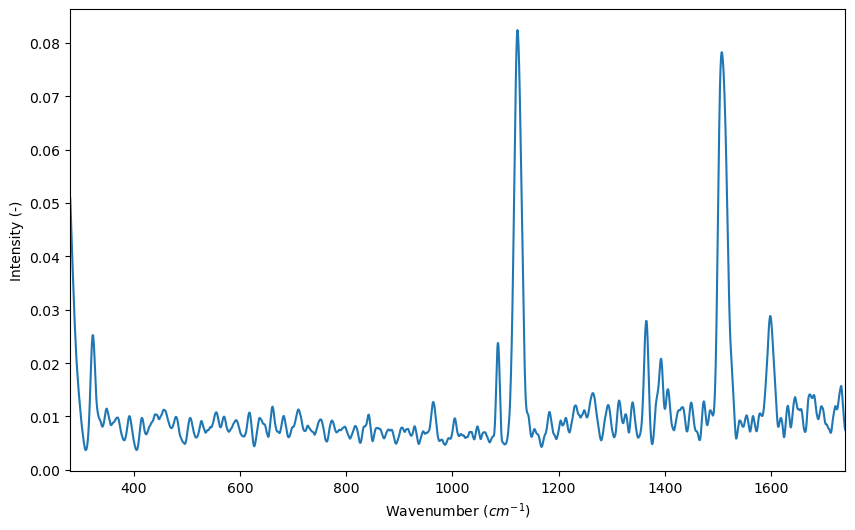

In [59]:
X_norm = Normalizer().fit_transform(X_smooth)

plt.plot(wns_reduced, X_norm.mean(axis=0))
plt.margins(x=0)

plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Intensity (-)")

In [60]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_norm)

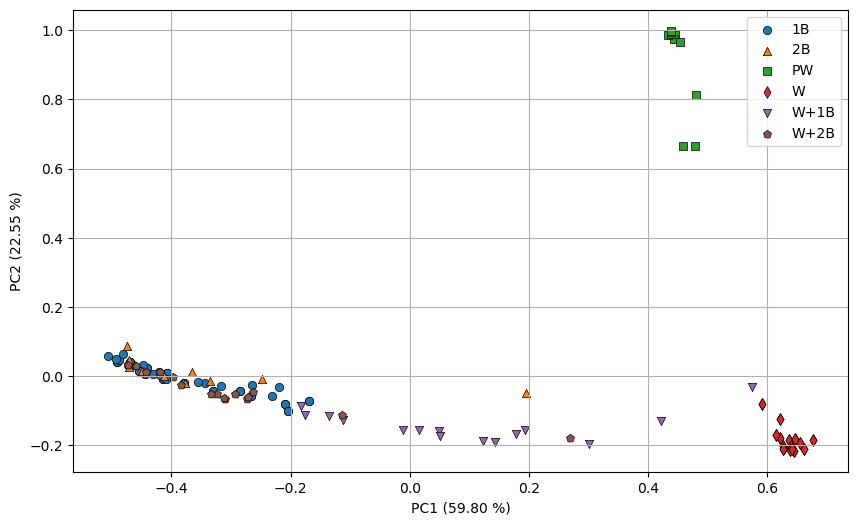

In [68]:
shapes = cycle(["o", "^", "s", "d", "v", "p", "P", "*", "<", ">"])

for i, marker in zip(range(len(y_key)), shapes):
    plt.scatter(X_pca[y==i, 0], X_pca[y==i, 1], label = y_key[i], marker=marker, edgecolors="k", linewidths=0.5)

plt.xlabel(f"PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f} %)")
plt.ylabel(f"PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f} %)")
plt.legend()

plt.grid()

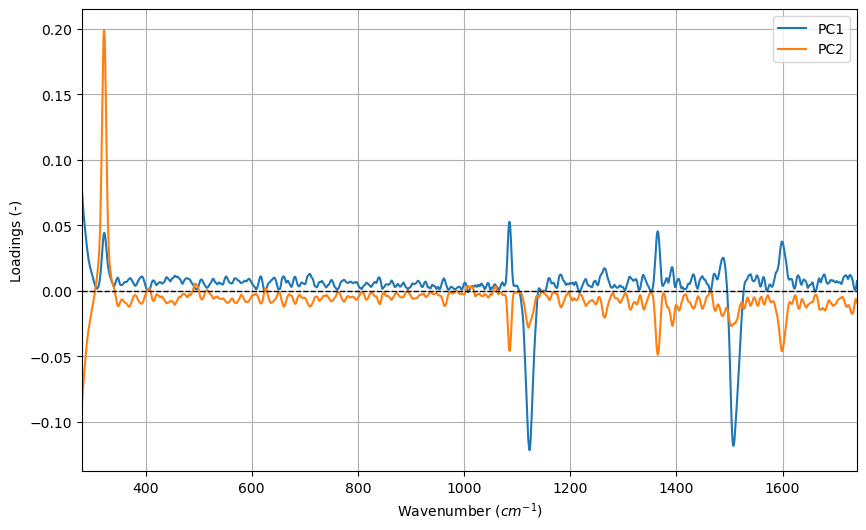

In [62]:
for i, component in enumerate(pca.components_):
    plt.plot(wns_reduced, component, label=f"PC{i+1}")


plt.axhline(y=0, linestyle="--", linewidth=1, color="k")

plt.margins(x=0)

plt.xlabel("Wavenumber ($cm^{-1}$)")
plt.ylabel("Loadings (-)")

plt.legend()

plt.grid()